<a href="https://colab.research.google.com/github/QuintessentialChicken98/Finance_Projects/blob/main/Technical_Analysis_Backtesting_Env.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Algorithmic Finance: 
*Backtesting various technical trading strategies for comparison for fun.*


# Introduction:
Welcome to this technical analysis backtesting notebook. Technical analysis is a popular methodology used by traders and investors to analyze financial markets and make trading decisions based on past price trends and chart patterns. In this notebook, we will explore the performance of a technical trading strategy by backtesting it on historical price data.

To evaluate the performance of our trading strategy, we will use various metrics to measure the risk and return characteristics of the strategy. These metrics include:

- Cumulative return: This metric measures the total return of the trading strategy over the backtesting period, expressed as a percentage of the initial investment.

- Logarithmic returns: This metric measures the compounded returns of the trading strategy over the backtesting period, using logarithmic returns to account for the effect of compounding.

- Annualised average return: This metric measures the average return of the trading strategy over the backtesting period, expressed as an annualized percentage.

- Annualised volatility: This metric measures the variability of returns of the trading strategy over the backtesting period, expressed as an annualized percentage.

- Sharpe Ratio: This metric measures the risk-adjusted return of the trading strategy by taking into account the excess return earned above the risk-free rate, relative to the volatility of the returns.

- Maximum Drawdown: This metric measures the largest peak-to-trough decline in the value of the investment over the backtesting period, expressed as a percentage of the peak value.

By analyzing these metrics, we can gain insights into the risk and return characteristics of our trading strategy, and make informed decisions about its suitability for our investment goals.

In [27]:
#@title Run Import Libraries (Necessary)
# Import Libraries 
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import matplotlib.ticker as mtick
import datetime

Enter ticker here: aapl
Do you want to specify dates? Y/Nn
[*********************100%***********************]  1 of 1 completed


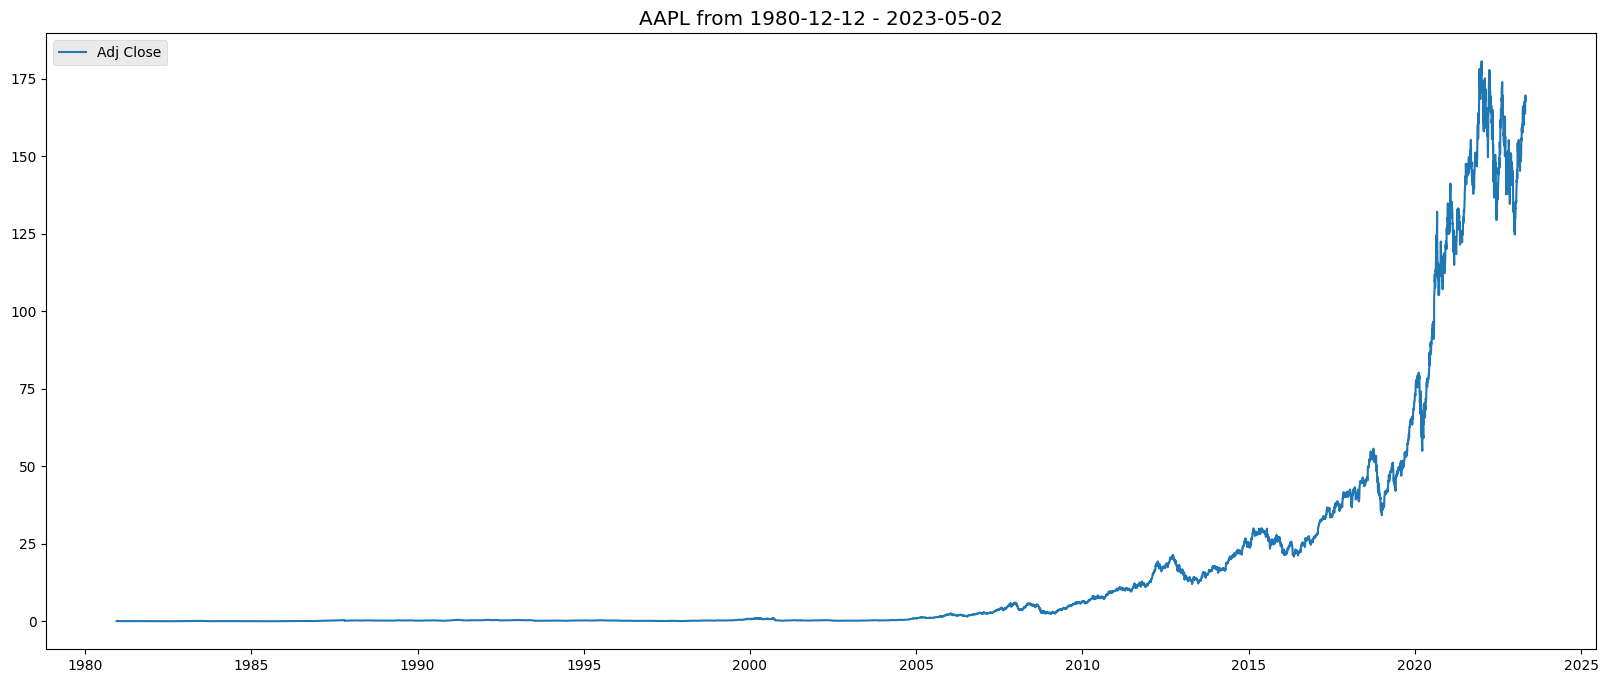

In [3]:
#@title Run to Obtain Equity data

ticker = input("Enter ticker here: " )
dates_question = input("Do you want to specify dates? Y/N")
if dates_question.lower() == 'y':
    start_date = input("Enter start date here (YYYY-MM-DD): ")   
    end_date = input("Enter end date here (YYYY-MM-DD): ")
    # download security data:
    security = yf.download(ticker, start_date, end_date)
    security.index = security.index.date
    # download risk free rate data:
    rf = pdr.get_data_fred('TB3MS', start_date, end_date)
elif dates_question.lower() == 'n':
    # download security data:
    security = yf.download(ticker, None, None) 
    security.index = security.index.date
    # download risk free rate data:
    rf = pdr.get_data_fred('TB3MS', None, None)
try:
    fig, ax = plt.subplots(figsize=(20,8))
    plt.style.use('ggplot')
    plt.plot(security['Adj Close'], label = 'Adj Close')
    plt.title(f'{ticker.upper()} from {security.index[0]} - {security.index[-1]}')
    plt.legend()
    plt.show();
except Exception as e:
    print(f"Error: {e}")



We have obtained some data, now lets run the most simple strategy - **Buy and Hold**: wherein we simply purchase the stock and hold it, no complex trading strategy. 

In [31]:
#@title Run to set up Buy and Hold function
# Buy and Hold as a Function
def buy_and_hold(security):
    while True:
        try:
            investment_question = input('Do you want to specify an initial investment sum? Y/N (Default = 10K)')
            if investment_question.lower() == 'y': 
                investment = float(input('Please state initial investment amount: ' ))
            elif investment_question.lower() == 'n':
                investment = 10000
            break
        except ValueError:
            print('Initial investment amount must be a number!')
        
    s_0 = security['Adj Close'][0] # Initial price of the stock
    portfolio = int(investment/s_0) # Portfolio of shares (cannot own half a share)   
    portfolio_value = portfolio*security['Adj Close']
    portfolio_log_return = np.log(portfolio_value/portfolio_value.shift(1))
    portfolio_cum_return = (portfolio_value[-1]/investment)-1
    portfolio_rolling_21d_std = portfolio_log_return.rolling(21).std()*np.sqrt(21)
    portfolio_std = np.std(portfolio_log_return)*np.sqrt(252) # annualised based on trading days per year
    portfolio_mean = np.mean(portfolio_log_return)
    annualised_mean = np.exp(portfolio_mean*252)-1
    sharpe_ratio = ((annualised_mean-rf['TB3MS'].mean())/portfolio_std)


    # Maximum Drawdown:
    investment_value_dates = security.index
    investment_value_dates = investment_value_dates.insert(0, security.index[0]) # on first day the value was the initial investment sum 
    investment_value_series_with_date = pd.Series(portfolio_value, index=investment_value_dates)
    investment_value_series_with_date.name = 'Investment Value'
    investment_value_series_with_date.index.name = 'Date'
    peak_idx = investment_value_series_with_date.idxmax()
    trough_idx = investment_value_series_with_date[peak_idx:].idxmin()
    peak_value = investment_value_series_with_date[peak_idx]
    trough_value = investment_value_series_with_date[trough_idx]
    maximum_drawdown = (trough_value - peak_value) / (1+peak_value)

# Visualisations:

    # Plot portfolio with maximum drawdown:
    plt.style.use('ggplot')
    fig, ax1 = plt.subplots(figsize=(20,6))
    plt.title(f'Buy and Hold Strategy {ticker.upper()}:')
    ax1.plot(investment_value_series_with_date, '#1CED54', label = 'Investment Value')
    # Obtain x and y values for maximum drawdown:
    x_values = [peak_idx, trough_idx]
    y_values = [peak_value, trough_value]
    ax1.plot(x_values, y_values, color = '#ed1d24', linestyle = '--', label = 'Maximum Drawdown')
    y_fmt = mtick.StrMethodFormatter('{x:,.0f}')
    ax1.yaxis.set_major_formatter(y_fmt)
    ax1.set_ylabel('Portfolio Value')
    # Plot Adj Close
    ax2 = ax1.twinx()
    ax2.plot(security['Adj Close'], alpha = 0.5)
    fig.legend(loc='upper left')
    ax2.set_ylabel('Adj Close Price')
    plt.xlabel('Date')
    plt.show();
    
    # Porftolio rolling volatility:
    fig, ax = plt.subplots(figsize = (20,8))
    plt.plot(portfolio_rolling_21d_std)
    plt.title('Portfolio Rolling Volatility Over Time')
    plt.ylabel('Portfolio Rolling Volatility (21D)')
    plt.xlabel('Date')
    fig.autofmt_xdate()
    plt.show();

    # Ouput metrics:
    print("Initial Investment:", format(investment, ','))
    print(f"Cumulative Portfolio Return: {portfolio_cum_return*100: .2f} %")
    print(f"Terminal Portfolio Value: {portfolio_value[-1]: ,.2f}")
    print(f"No. Purchased: {portfolio: ,}")
    print(f"Annualised Average Portfolio Return: {annualised_mean*100: .2f} %")
    print(f"Annualised Portfolio Volatility: {portfolio_std*100: .2f} %")
    print(f"Portfolio Sharpe Ratio: {sharpe_ratio: .2f}")
    print(f"Portfolio Maximum Drawdown: {maximum_drawdown*100: .2f} %")
    

Do you want to specify an initial investment sum? Y/N (Default = 10K)n


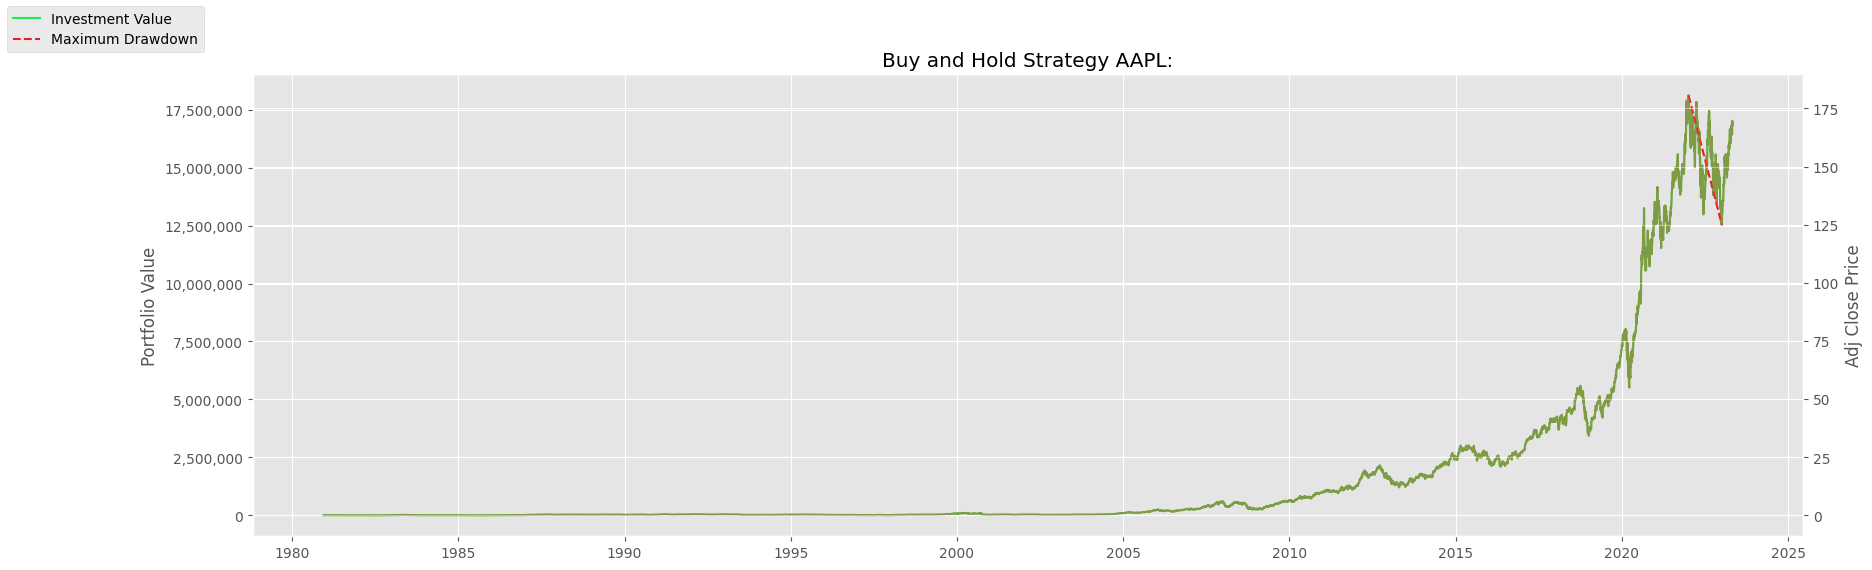

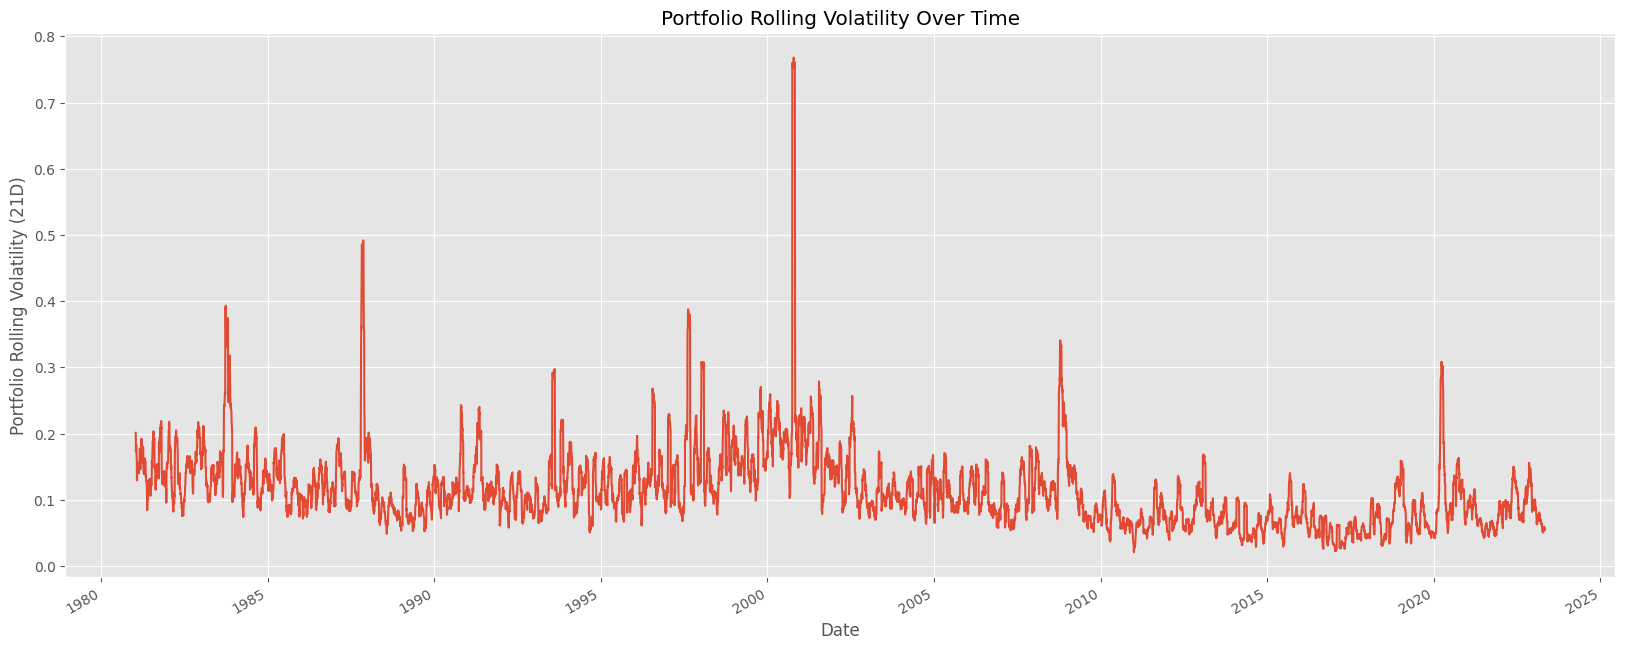

Initial Investment: 10,000
Cumulative Portfolio Return:  168283.48 %
Terminal Portfolio Value:  16,838,347.61
No. Purchased:  100,279
Annualised Average Portfolio Return:  19.15 %
Annualised Portfolio Volatility:  45.44 %
Portfolio Sharpe Ratio: -2.85
Portfolio Maximum Drawdown: -30.91 %


In [32]:
buy_and_hold(security)

# Time to try out some technical analysis trading strategies!

*Technical Analysis*: involves the use of past price-related information alone to inform investment decisions such as entry and exit points, via pattern recognition and algorithms.

# MOVING AVERAGE CROSSOVER:

*Explanation*:<br>
This algorithm is based on the crossover of two moving averages, where the shorter-term moving average crosses above or below the longer-term moving average.<br>

**Trading Rules:**
- Buy signal: When a short-term moving average (e.g., 50-day) crosses above a long-term moving average (e.g., 200-day), it may signal a buy opportunity as the security is experiencing an upward trend.
- Sell signal: When a short-term moving average (e.g., 50-day) crosses below a long-term moving average (e.g., 200-day), it may signal a sell opportunity as the security is experiencing a downward trend.


In [40]:
#@title Run to set up Moving Average Crossover function
def moving_averages (security):
    while True:
        try:
            investment_question = input('Do you want to specify an initial investment sum? Y/N (Default = 10K)')
            if investment_question.lower() == 'y': 
                investment = float(input('Please state initial investment amount: ' ))
            elif investment_question.lower() == 'n':
                investment = 10000 
            fast = int(input('Enter fast moving average here:' ))
            slow = int(input('Enter slow moving average here:'))          
            ma_condition = int(fast) < int(slow)
            break
        except ValueError:
            print('Initial investment amount must be a number!')
            print('Moving averages must be integers!')
        
    if not ma_condition:
            print('Fast moving average must be less than slow moving average.')
            print("The fast moving average is {} and the slow moving average is {}.".format(fast, slow))
    else:
        fast_ma = security['Adj Close'].rolling(int(fast)).mean()
        slow_ma = security['Adj Close'].rolling(int(slow)).mean()
        
    # Generate crossings:
    golden_crosses = pd.Series((fast_ma > slow_ma) & (fast_ma.shift() < slow_ma.shift()))
    death_crosses = pd.Series((fast_ma < slow_ma) & (fast_ma.shift() > slow_ma.shift()))

    

    # Set the first value of death_crosses to False (to avoid a death cross occurring before a golden cross)
    death_crosses.iloc[0] = False

    # Initialize variables for tracking the current state
    in_position = False
    entries = []
    entries_idxpos = []
    num_shares = []
    entries_value = []
    exits = []
    exits_idxpos = []
    exits_value = []
    profits = []
    investment = investment # starting investment amount
    investment_value = [investment] # initial investment

    # Loop over the index positions where signals occur
    for i in range(len(security)):
        # If we're not currently in a position and a golden cross occurs, enter a long position
        if not in_position and golden_crosses[i]:
            in_position = True
            entries.append(security.iloc[i]["Adj Close"])
            entries_idxpos.append(i)
            num_shares.append(int(investment/security.iloc[i]["Adj Close"]))
            entries_value.append(num_shares[-1]*security.iloc[i]["Adj Close"])
        # If we're in a long position and a death cross occurs, exit the position
        elif in_position and death_crosses[i]:
            in_position = False
            exits.append(security.iloc[i]["Adj Close"])
            exits_idxpos.append(i)
            exits_value.append(num_shares[-1]*security.iloc[i]["Adj Close"])
            profits.append(exits_value[-1] - entries_value[-1])
            investment += profits[-1]
# Calculate the current value of the investment and append to investment_value
            current_value = investment + num_shares[-1]*(security.iloc[i]["Adj Close"] - entries[-1])
            investment_value.append(current_value)
    # Convert entries and exits values into arrays ahead of calculating log returns:
    entries_value_array = np.array(entries_value)
    exits_value_array = np.array(exits_value)

    # Check their shapes match to avoid ValueError:
    shape1 = entries_value_array.shape
    shape2 = exits_value_array.shape

    # If there is one more entry than exits remove the last entry as no returns can be caluclated anyway:
    if shape1 == shape2:
        pass
    elif shape1>shape2:
        entries_value_array = entries_value_array[:-1]

    # Calcualte the returns:
    log_returns = np.log(exits_value_array/entries_value_array)
    vol_returns = np.std(log_returns)
    annualised_vol = vol_returns*np.sqrt(252) # trading days in a year
    mean_return = np.mean(log_returns)
    annualised_mean = np.exp(mean_return*252)-1
    total_log_return = sum(log_returns)
    sharpe_ratio = ((annualised_mean-rf['TB3MS'].mean())/annualised_vol)

    entry_dates = security.index[entries_idxpos]
    exit_dates = security.index[exits_idxpos]
    total_profits = sum(profits)
    intial_investment = investment - total_profits
    portfolio_cum_returns = ((investment / intial_investment - 1))
    

    # Maximum Drawdown:
    investment_value_dates = security.index[exits_idxpos]
    investment_value_dates = investment_value_dates.insert(0, security.index[0]) # on first day the value was the initial investment sum 
    investment_value_series_with_date = pd.Series(investment_value, index=investment_value_dates)
    investment_value_series_with_date.name = 'Investment Value'
    investment_value_series_with_date.index.name = 'Date'
    peak_idx = investment_value_series_with_date.idxmax()
    trough_idx = investment_value_series_with_date[peak_idx:].idxmin()
    peak_value = investment_value_series_with_date[peak_idx]
    trough_value = investment_value_series_with_date[trough_idx]
    maximum_drawdown = (trough_value - peak_value) / (1+peak_value)
   

    # Plot max drawdown
    fig, ax1 = plt.subplots(figsize=(20,6))
    ax1.plot(investment_value_series_with_date, '#1CED54', label = 'Investment Value')
    # Obtain x and y values for maximum drawdown:
    x_values = [peak_idx, trough_idx]
    y_values = [peak_value, trough_value]
    ax1.plot(x_values, y_values, color = '#ed1d24', linestyle = '--', label = 'Maximum Drawdown')
    y_fmt = mtick.StrMethodFormatter('{x:,.0f}')
    ax1.yaxis.set_major_formatter(y_fmt)
    # Plot Adj Close
    ax2 = ax1.twinx()
    ax2.plot(security['Adj Close'], alpha = 0.5)
    ax1.legend(loc='upper left')
    plt.show();

    fig, ax = plt.subplots(figsize=(20,6))
    plt.title(f'Moving Averages for {ticker.upper()}')
    plt.plot(security['Adj Close'], label = ticker.upper())
    plt.plot(fast_ma, label = f'Fast MA: {int(fast)} Days')
    plt.plot(slow_ma, label = f'Slow MA: {int(slow)} Days')
    ax.plot(entry_dates,security['Adj Close'][entry_dates], marker = '^', color = '#08FF08', linestyle = '')
    ax.plot(exit_dates, security['Adj Close'][exit_dates], marker = 'v', color = 'red', linestyle = '')
    fig.autofmt_xdate()
    plt.ylabel('Adj Close')
    plt.legend(loc='best')
    plt.show()
    
    
    print('Portfolio initial value: ', format(intial_investment, ','))
    print('Portfolio Terminal Value: ', format(round(investment, 2), ','))
    print("Strategy Cumulative Return: ", round(portfolio_cum_returns*100, 2), "%")
    print("Total Gross Profits:", round(sum(profits), 2))
    print("Average Trade Gross Profit:", round(sum(profits)/len(profits), 2))
    print("Largest Profit: ", format(round(max(profits), 2), ','))
    print("Largest Loss: ", format(round(min(profits), 2), ','))
    print("Total Trades: ", len(entries)+len(exits))
    print("Strategy Annualised Mean Return: ", round(annualised_mean*100, 2), "%")
    print("Total Log Return: ", round(total_log_return*100, 2), "%")
    print("Strategy Annualised Volatility: ", round(annualised_vol, 2)*100, "%")
    print("Strategy Sharpe Ratio: ", sharpe_ratio)
    print("Strategy Maximum Drawdown: ", round(maximum_drawdown*100, 2), "%")

    # Create Orderbook:
    exit_dates_list = exit_dates.to_list()
    exit_dates_series = pd.Series(exit_dates_list)
    entry_dates_list = entry_dates.to_list()
    entry_dates_series = pd.Series(entry_dates_list)
    max_len = len(entry_dates_series)

    # Use a for loop to append NaN values to each array until its length matches the maximum length.
    for arr in [entries, num_shares, exits, profits]:
        arr.extend([np.nan] * (max_len - len(arr)))
    # Extend the Exit dates:
    exit_dates = pd.concat([exit_dates_series, pd.Series([np.nan] * (len(entries) - len(exit_dates)))])
    # Create a dictionary of the orderbook components:
    data = {'Entry Date': entry_dates_series,
            'Entry Price': entries, 
            'Shares Purchased': num_shares, 
            'Exit Date':exit_dates_series, 
            'Exit Price': exits, 
            'Gross Profit': profits}
    pd.options.display.float_format = '{:,.2f}'.format

    orderbook = pd.DataFrame(data)

    
    return orderbook


Do you want to specify an initial investment sum? Y/N (Default = 10K)n
Enter fast moving average here:10
Enter slow moving average here:100


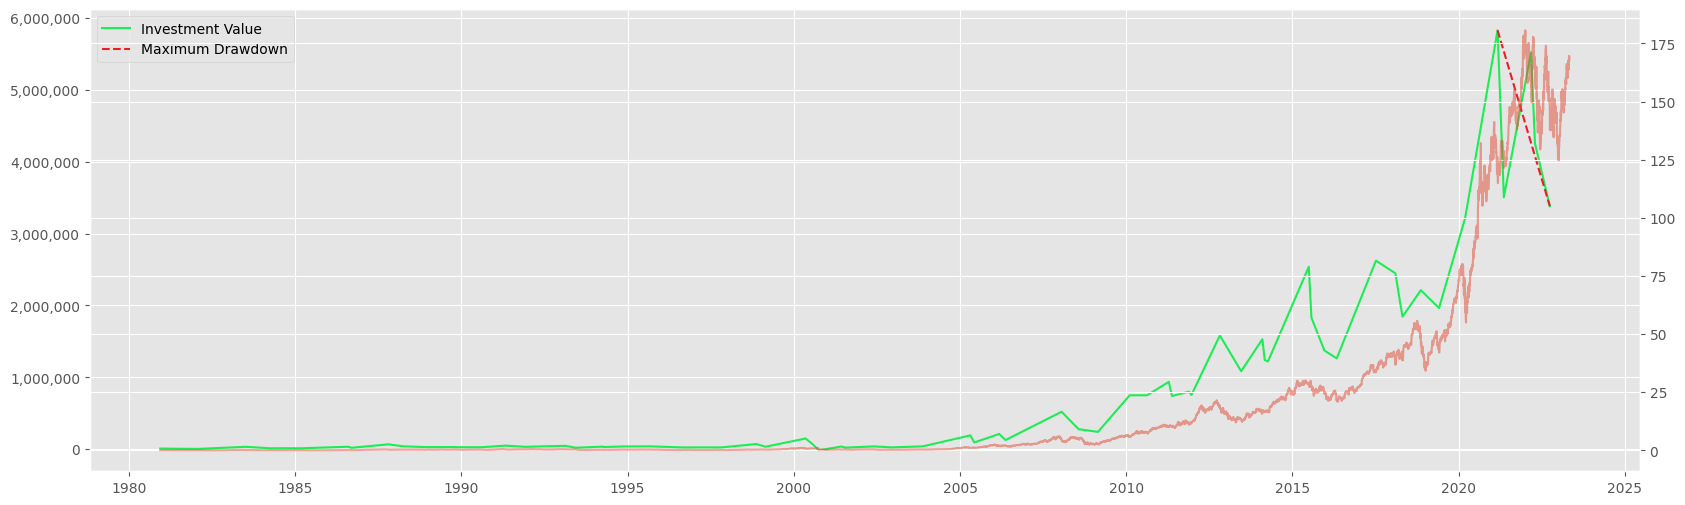

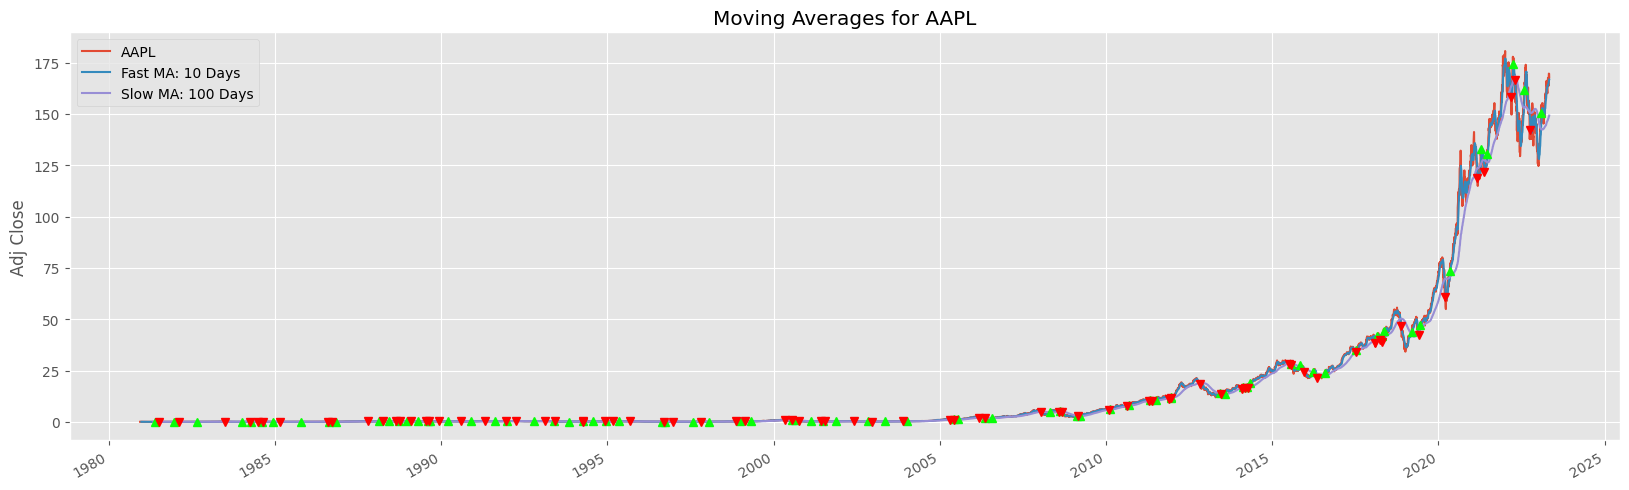

Portfolio initial value:  10,000.0
Portfolio Terminal Value:  3,925,999.49
Strategy Cumulative Return:  39159.99 %
Total Gross Profits: 3915999.49
Average Trade Gross Profit: 51526.31
Largest Profit:  1,601,683.85
Largest Loss:  -545,698.36
Total Trades:  153
Strategy Annualised Mean Return:  39903861709.94 %
Total Log Return:  597.28 %
Strategy Annualised Volatility:  498.00000000000006 %
Strategy Sharpe Ratio:  80095632.43315056
Strategy Maximum Drawdown:  -41.98 %


,Entry Date,Entry Price,Shares Purchased,Exit Date,Exit Price,Gross Profit
0,1981-05-21,0.10,96100,1981-07-07,0.09,"-1,625.03"
1,1981-12-21,0.08,110378,1982-02-17,0.06,"-1,244.29"
2,1982-08-24,0.06,127490,1983-07-07,0.16,"13,542.59"
3,1984-01-05,0.10,210979,1984-04-06,0.08,"-3,475.98"
4,1984-04-18,0.10,177072,1984-07-02,0.09,"-1,458.74"
...,...,...,...,...,...,...
72,2021-04-13,132.83,31800,2021-05-12,121.52,"-359,824.60"
73,2021-06-17,130.44,29624,2022-03-07,158.34,"826,425.34"
74,2022-03-28,174.54,26874,2022-04-19,166.39,"-219,039.75"
75,2022-07-29,161.77,27642,2022-09-29,142.03,"-545,698.36"


In [41]:
moving_averages(security)

# MACD:

*Explanation*: <br>
This algorithm uses the MACD (Moving Average Convergence-Divergence) indicator to identify trend reversals. A buy signal is generated when the MACD line crosses above the signal line, while a sell signal is generated when the MACD line crosses below the signal line.<br>

**Trading Rules:**
- Buy signal: When the MACD line crosses above the signal line, it may signal a buy opportunity as the security is experiencing a bullish trend.
- Sell signal: When the MACD line crosses below the signal line, it may signal a sell opportunity as the security is experiencing a bearish trend.

In [38]:
#@title Run to set up MACD function
def macd (security):
    while True:
        try:
            investment_question = input('Do you want to specify an initial investment sum? Y/N (Default = 10K)')
            if investment_question.lower() == 'y': 
                investment = float(input('Please state initial investment amount: ' ))
            elif investment_question.lower() == 'n':
                investment = 10000  
            break
        except ValueError:
            print('Initial investment amount must be a number!')
        

    # Generate MACD Strategy:
    ema_26 = security['Adj Close'].ewm(26).mean()
    ema_12 = security['Adj Close'].ewm(12).mean()
    macd = ema_12-ema_26
    macd_9 = macd.ewm(9).mean()
    macd_h = macd-macd_9
    
    # Generate MACD Signals 
    macd_buy = pd.Series((macd > macd_9) & (macd.shift() < macd_9.shift()))
    macd_sell = pd.Series((macd < macd_9) & (macd.shift() > macd_9.shift()))

    # Set the first value of macd sell signals to False (No Short Selling):
    macd_sell.iloc[0] = False

    # Initialize variables for tracking the current state
    in_position = False
    entries = []
    entries_idxpos = []
    num_shares = []
    entries_value = []
    exits = []
    exits_idxpos = []
    exits_value = []
    profits = []
    investment = investment # starting investment amount
    investment_value = [investment] # initial investment

    # Loop over the index positions where signals occur
    for i in range(len(security)):
        # If we're not currently in a position and a macd buy signal occurs, enter a long position
        if not in_position and macd_buy[i]:
            in_position = True
            entries.append(security.iloc[i]["Adj Close"])
            entries_idxpos.append(i)
            num_shares.append(int(investment/security.iloc[i]["Adj Close"]))
            entries_value.append(num_shares[-1]*security.iloc[i]["Adj Close"])
        # If we're in a long position and a macd sell signal occurs, exit the position
        elif in_position and macd_sell[i]:
            in_position = False
            exits.append(security.iloc[i]["Adj Close"])
            exits_idxpos.append(i)
            exits_value.append(num_shares[-1]*security.iloc[i]["Adj Close"])
            profits.append(exits_value[-1] - entries_value[-1])
            investment += profits[-1]
    # Calculate the current value of the investment and append to investment_value
            current_value = investment + num_shares[-1]*(security.iloc[i]["Adj Close"] - entries[-1])
            investment_value.append(current_value)
    # Convert entries and exits values into arrays ahead of calculating log returns:
    entries_value_array = np.array(entries_value)
    exits_value_array = np.array(exits_value)

    # Check their shapes match to avoid ValueError:
    shape1 = entries_value_array.shape
    shape2 = exits_value_array.shape

    # If there is one more entry than exits remove the last entry as no returns can be caluclated anyway:
    if shape1 == shape2:
        pass
    elif shape1>shape2:
        entries_value_array = entries_value_array[:-1]

    # Calcualte the returns:
    log_returns = np.log(exits_value_array/entries_value_array)
    vol_returns = np.std(log_returns)
    annualised_vol = vol_returns*np.sqrt(252) # trading days in a year
    mean_return = np.mean(log_returns)
    annualised_mean = np.exp(mean_return*252)-1
    total_log_return = sum(log_returns)
    sharpe_ratio = ((annualised_mean-rf['TB3MS'].mean())/annualised_vol)

    entry_dates = security.index[entries_idxpos]
    exit_dates = security.index[exits_idxpos]
    total_profits = sum(profits)
    intial_investment = investment - total_profits
    portfolio_cum_returns = ((investment / intial_investment - 1))
    

    # Maximum Drawdown:
    investment_value_dates = security.index[exits_idxpos]
    investment_value_dates = investment_value_dates.insert(0, security.index[0]) # on first day the value was the initial investment sum 
    investment_value_series_with_date = pd.Series(investment_value, index=investment_value_dates)
    investment_value_series_with_date.name = 'Investment Value'
    investment_value_series_with_date.index.name = 'Date'
    peak_idx = investment_value_series_with_date.idxmax()
    trough_idx = investment_value_series_with_date[peak_idx:].idxmin()
    peak_value = investment_value_series_with_date[peak_idx]
    trough_value = investment_value_series_with_date[trough_idx]
    maximum_drawdown = (trough_value - peak_value) / (1+peak_value)
   

     # Plot max drawdown
    fig, ax1 = plt.subplots(figsize=(20,6))
    ax1.plot(investment_value_series_with_date, '#1CED54', label = 'Investment Value')
    # Obtain x and y values for maximum drawdown:
    x_values = [peak_idx, trough_idx]
    y_values = [peak_value, trough_value]
    ax1.plot(x_values, y_values, color = '#ed1d24', linestyle = '--', label = 'Maximum Drawdown')
    y_fmt = mtick.StrMethodFormatter('{x:,.0f}')
    ax1.yaxis.set_major_formatter(y_fmt)
    # Plot Adj Close
    ax2 = ax1.twinx()
    ax2.plot(security['Adj Close'], alpha = 0.5)
    ax1.legend(loc='upper left')
    plt.show();

    # Plot the MACD lines and histogram:
    # Set up plots:
    fig, ax3,   = plt.subplots(figsize = (20,6))
    ax4 = ax3.twinx

    # Plot values:
    ax3.plot(macd_9, label = 'Signal Line')
    ax3.plot(macd, label = 'MACD')
    ax3.axhline(y=0, color = 'black', linestyle='--', linewidth = 1)
    ax3.plot(entry_dates,macd[entry_dates], marker = '^', color = '#08FF08', linestyle = '')
    ax3.plot(exit_dates, macd[exit_dates], marker = 'v', color = 'red', linestyle = '')
    colors = np.where(macd_h >= 0, 'gold', 'goldenrod')
    plt.bar(macd_h.index, macd_h, color = colors, label = 'MACD Histogram')
    plt.ylabel('Convergence-Divergence')
    # Legend etc.:
    plt.legend(loc= 'upper right')
    plt.title(f'Moving Average Convergence Divergence (MACD) for {ticker.upper()}')
    fig.autofmt_xdate()
    plt.show()

    print('Portfolio initial value: ', format(intial_investment, ','))
    print('Portfolio Terminal Value: ', format(round(investment, 2), ','))
    print("Strategy Cumulative Return: ", round(portfolio_cum_returns*100, 2), "%")
    print("Total Gross Profits:", round(sum(profits), 2))
    print("Average Trade Gross Profit:", round(sum(profits)/len(profits), 2))
    print("Largest Profit: ", format(round(max(profits), 2), ','))
    print("Largest Loss: ", format(round(min(profits), 2), ','))
    print("Total Trades: ", len(entries)+len(exits))
    print("Strategy Annualised Mean Return: ", round(annualised_mean*100, 2), "%")
    print("Total Log Return: ", round(total_log_return*100, 2), "%")
    print("Strategy Annualised Volatility: ", round(annualised_vol, 2)*100, "%")
    print("Strategy Sharpe Ratio: ", sharpe_ratio)
    print("Strategy Maximum Drawdown: ", round(maximum_drawdown*100, 2), "%")


    
    # Create Orderbook:
    exit_dates_list = exit_dates.to_list()
    exit_dates_series = pd.Series(exit_dates_list)
    entry_dates_list = entry_dates.to_list()
    entry_dates_series = pd.Series(entry_dates_list)
    max_len = len(entry_dates_series)

    # Use a for loop to append NaN values to each array until its length matches the maximum length.
    for arr in [entries, num_shares, exits, profits]:
        arr.extend([np.nan] * (max_len - len(arr)))
    # Extend the Exit dates:
    exit_dates = pd.concat([exit_dates_series, pd.Series([np.nan] * (len(entries) - len(exit_dates)))])
    # Create a dictionary of the orderbook components:
    data = {'Entry Date': entry_dates_series,
            'Entry Price': entries, 
            'Shares Purchased': num_shares, 
            'Exit Date':exit_dates_series, 
            'Exit Price': exits, 
            'Gross Profit': profits}
    pd.options.display.float_format = '{:,.2f}'.format

    orderbook = pd.DataFrame(data)

    
    return orderbook


Do you want to specify an initial investment sum? Y/N (Default = 10K)n


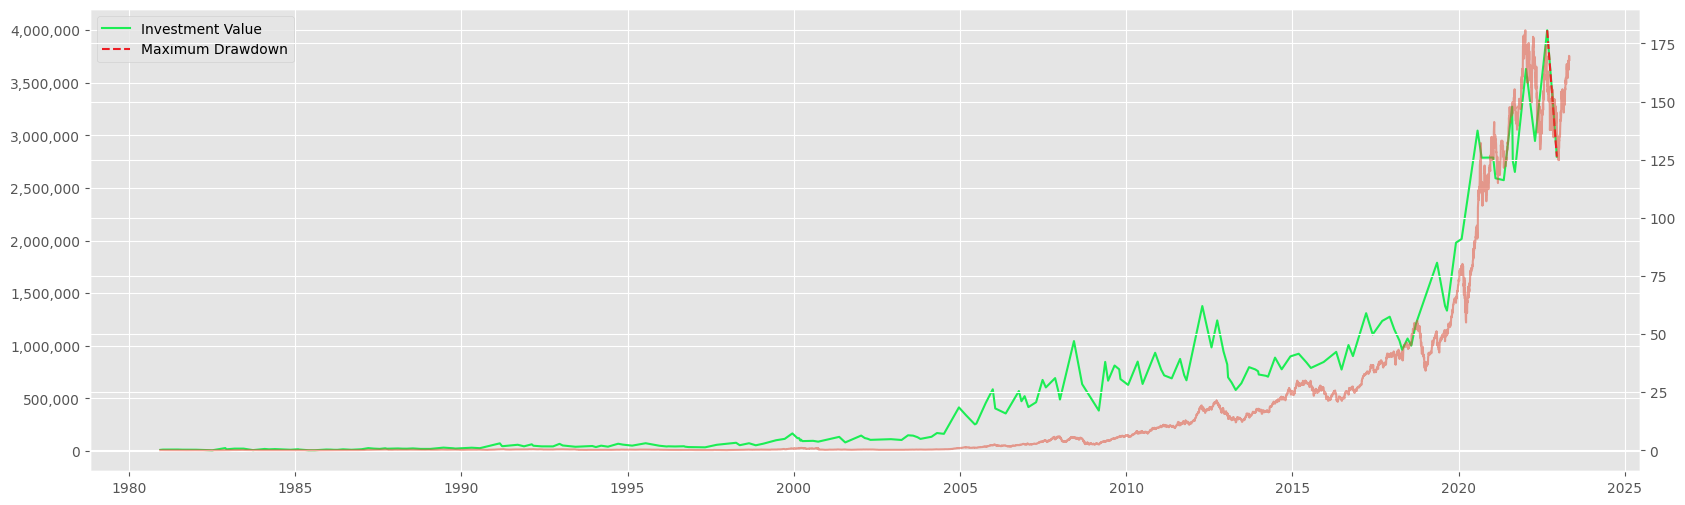

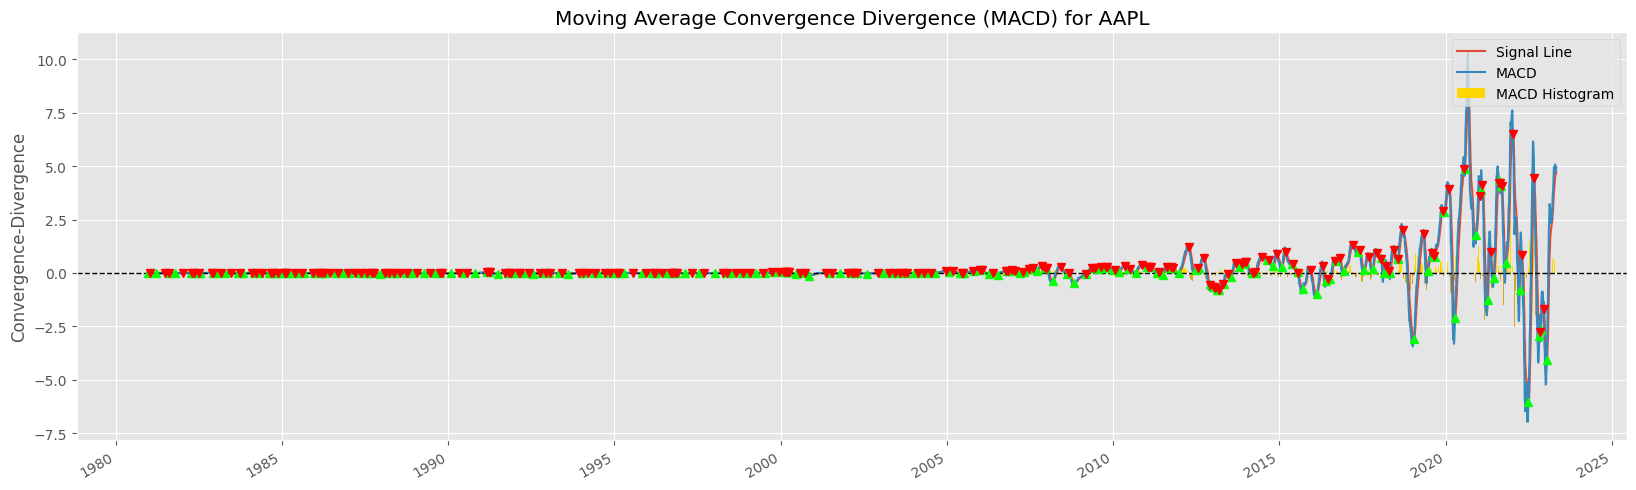

Portfolio initial value:  10,000.0
Portfolio Terminal Value:  3,096,201.48
Strategy Cumulative Return:  30862.01 %
Total Gross Profits: 3086201.48
Average Trade Gross Profit: 15508.55
Largest Profit:  599,420.01
Largest Loss:  -299,407.12
Total Trades:  399
Strategy Annualised Mean Return:  142537.66 %
Total Log Return:  573.54 %
Strategy Annualised Volatility:  233.0 %
Strategy Sharpe Ratio:  612.234729571837
Strategy Maximum Drawdown:  -30.05 %


,Entry Date,Entry Price,Shares Purchased,Exit Date,Exit Price,Gross Profit
0,1980-12-19,0.10,102054,1981-01-09,0.11,"1,283.19"
1,1981-03-23,0.09,121605,1981-06-22,0.10,"1,001.70"
2,1981-08-11,0.08,144561,1981-08-12,0.08,-250.69
3,1981-10-08,0.06,187540,1982-01-12,0.06,-325.23
4,1982-04-01,0.06,190181,1982-04-22,0.05,"-1,566.74"
...,...,...,...,...,...,...
195,2022-03-24,173.02,18441,2022-04-19,166.39,"-122,260.54"
196,2022-06-30,136.10,22546,2022-08-31,156.72,"464,986.48"
197,2022-10-27,144.34,24480,2022-11-07,138.71,"-137,861.74"
198,2022-11-11,149.47,22717,2022-12-15,136.29,"-299,407.12"


In [39]:
macd(security)

# RSI:


*Explanation*:<br>
This algorithm uses the RSI (Relative Strength Index) indicator to identify overbought and oversold conditions in a market. When the RSI reaches a certain level, it may indicate a potential trend reversal.<br>

**Trading Rules:**
- Buy signal: When the RSI falls below 30 and then rises above it, it may signal a buy opportunity as the security may be oversold and may experience an upward price movement.
- Sell signal: When the RSI rises above 70 and then falls below it, it may signal a sell opportunity as the security may be overbought and may experience a downward price movement.

In [36]:
#@title Run to set up RSI function
def rsi (security):
    while True:
        try:
            investment_question = input('Do you want to specify an initial investment sum? Y/N (Default = 10K)')
            if investment_question.lower() == 'y': 
                investment = float(input('Please state initial investment amount: ' ))
            elif investment_question.lower() == 'n':
                investment = 10000  
            n_question = input('Do you want to specify a lookback period? Y/N (Default = 14)')
            if n_question.lower() == 'y': 
                n = int(input('Please state lookback period: '))
            elif n_question.lower() == 'n':
                n = 14
            break
        except ValueError:
            print('Initial investment amount must be a number!')
            print('Lookback period must be an integer!')

# RSI 

    n = n # look-back period
    delta = np.log(security['Adj Close'])-np.log(security['Adj Close'].shift(1)) # price difference
    delta[1:] # drop the initial NaN
    gains = delta.copy()
    losses = delta.copy()
    gains[gains<0]=0 # where gains<0 set to 0
    losses[losses>0]=0 # where losses>0 set to 0
    avg_gain = gains.rolling(n).mean()
    avg_loss = abs(losses.rolling(n).mean())
    rs = avg_gain/avg_loss
    rsi = 100 - (100/(1+ rs))

    # Generate RSI Signals 
    rsi_buy = pd.Series((rsi < 30) & (rsi.shift() > 20))
    rsi_sell = pd.Series((rsi > 70) & (rsi.shift() < 80))


    # Set the first value of macd sell signals to False (No Short Selling):
    rsi_sell.iloc[0] = False

    # Initialize variables for tracking the current state
    in_position = False
    entries = []
    entries_idxpos = []
    num_shares = []
    entries_value = []
    exits = []
    exits_idxpos = []
    exits_value = []
    profits = []
    investment = investment # starting investment amount
    investment_value = [investment]

    # Loop over the index positions where signals occur
    for i in range(len(security)):
        # If we're not currently in a position and a macd buy signal occurs, enter a long position
        if not in_position and rsi_buy[i]:
            in_position = True
            entries.append(security.iloc[i]["Adj Close"])
            entries_idxpos.append(i)
            num_shares.append(int(investment/security.iloc[i]["Adj Close"]))
            entries_value.append(num_shares[-1]*security.iloc[i]["Adj Close"])
        # If we're in a long position and a macd sell signal occurs, exit the position
        elif in_position and rsi_sell[i]:
            in_position = False
            exits.append(security.iloc[i]["Adj Close"])
            exits_idxpos.append(i)
            exits_value.append(num_shares[-1]*security.iloc[i]["Adj Close"])
            profits.append(exits_value[-1] - entries_value[-1])
            investment += profits[-1]
            # Calculate the current value of the investment and append to investment_value
            current_value = investment + num_shares[-1]*(security.iloc[i]["Adj Close"] - entries[-1])
            investment_value.append(current_value)
    # Convert entries and exits values into arrays ahead of calculating log returns:
    entries_value_array = np.array(entries_value)
    exits_value_array = np.array(exits_value)

    # Check their shapes match to avoid ValueError:
    shape1 = entries_value_array.shape
    shape2 = exits_value_array.shape

    # If there is one more entry than exits remove the last entry as no returns can be caluclated anyway:
    if shape1 == shape2:
        pass
    elif shape1>shape2:
        entries_value_array = entries_value_array[:-1]

    # Calcualte the returns:
    log_returns = np.log(exits_value_array/entries_value_array)
    vol_returns = np.std(log_returns)
    annualised_vol = vol_returns*np.sqrt(252) # trading days in a year
    mean_return = np.mean(log_returns)
    annualised_mean = np.exp(mean_return*252)-1
    total_log_return = sum(log_returns)
    sharpe_ratio = ((annualised_mean-rf['TB3MS'].mean())/annualised_vol)

    entry_dates = security.index[entries_idxpos]
    exit_dates = security.index[exits_idxpos]
    total_profits = sum(profits)
    intial_investment = investment - total_profits
    portfolio_cum_returns = ((investment / intial_investment - 1))
    

    # Maximum Drawdown:
    investment_value_dates = security.index[exits_idxpos]
    investment_value_dates = investment_value_dates.insert(0, security.index[0]) # on first day the value was the initial investment sum 
    investment_value_series_with_date = pd.Series(investment_value, index=investment_value_dates)
    investment_value_series_with_date.name = 'Investment Value'
    investment_value_series_with_date.index.name = 'Date'
    peak_idx = investment_value_series_with_date.idxmax()
    trough_idx = investment_value_series_with_date[peak_idx:].idxmin()
    peak_value = investment_value_series_with_date[peak_idx]
    trough_value = investment_value_series_with_date[trough_idx]
    maximum_drawdown = (trough_value - peak_value) / (1+peak_value)
    

     # Plot max drawdown
    fig, ax1 = plt.subplots(figsize=(20,6))
    ax1.plot(investment_value_series_with_date, '#1CED54', label = 'Investment Value')
    # Obtain x and y values for maximum drawdown:
    x_values = [peak_idx, trough_idx]
    y_values = [peak_value, trough_value]
    ax1.plot(x_values, y_values, color = '#ed1d24', linestyle = '--', label = 'Maximum Drawdown')
    y_fmt = mtick.StrMethodFormatter('{x:,.0f}')
    ax1.yaxis.set_major_formatter(y_fmt)
    # Plot Adj Close
    ax2 = ax1.twinx()
    ax2.plot(security['Adj Close'], alpha = 0.5)
    ax1.legend(loc='upper left')
    plt.show();

# Plot the RSI strategy:
    # Set up plots:
    fig, ax,   = plt.subplots(figsize = (20,6))
    # Plot values:
    ax.plot(rsi, label = 'RSI')
    ax.axhline(y=70, color = 'red', linestyle='--', linewidth = 1, label = 'Overbought')
    ax.axhline(y=30, color = 'green', linestyle='--', label='Oversold')
    ax.plot(entry_dates, rsi[entry_dates], marker = '^', color = '#08FF08', linestyle = '')
    ax.plot(exit_dates, rsi[exit_dates], marker = 'v', color = 'red', linestyle = '')
    plt.ylabel('Relative Strength')
    # Legend etc.:
    plt.legend(loc= 'upper right')
    plt.title(f'Relative Strength Index (RSI) Strategy for {ticker.upper()}')
    fig.autofmt_xdate()
    plt.show()
    
    print('Portfolio initial value: ', format(intial_investment, ','))
    print('Portfolio Terminal Value: ', format(round(investment, 2), ','))
    print("Strategy Cumulative Return: ", round(portfolio_cum_returns*100, 2), "%")
    print("Average Trade Gross Profit:", round(sum(profits)/len(profits), 2))
    print("Largest Profit: ", format(round(max(profits), 2), ','))
    print("Largest Loss: ", format(round(min(profits), 2), ','))
    print("Total Trades: ", len(entries)+len(exits))
    print("Strategy Annualised Mean Return: ", round(annualised_mean*100, 2), "%")
    print("Total Log Return: ", round(total_log_return*100, 2), "%")
    print("Strategy Annualised Volatility: ", round(annualised_vol, 2)*100, "%")
    print("Strategy Sharpe Ratio: ", sharpe_ratio)
    print("Strategy Maximum Drawdown: ", round(maximum_drawdown*100, 2), "%")


    # Create Orderbook:
    exit_dates_list = exit_dates.to_list()
    exit_dates_series = pd.Series(exit_dates_list)
    entry_dates_list = entry_dates.to_list()
    entry_dates_series = pd.Series(entry_dates_list)
    max_len = len(entry_dates_series)

    # Use a for loop to append NaN values to each array until its length matches the maximum length.
    for arr in [entries, num_shares, exits, profits]:
        arr.extend([np.nan] * (max_len - len(arr)))
    # Extend the Exit dates:
    exit_dates = pd.concat([exit_dates_series, pd.Series([np.nan] * (len(entries) - len(exit_dates)))])
    # Create a dictionary of the orderbook components:
    data = {'Entry Date': entry_dates_series,
            'Entry Price': entries, 
            'Shares Purchased': num_shares, 
            'Exit Date':exit_dates_series, 
            'Exit Price': exits, 
            'Gross Profit': profits}
    pd.options.display.float_format = '{:,.2f}'.format

    orderbook = pd.DataFrame(data)


    
    return orderbook

Do you want to specify an initial investment sum? Y/N (Default = 10K)n
Do you want to specify a lookback period? Y/N (Default = 14)n


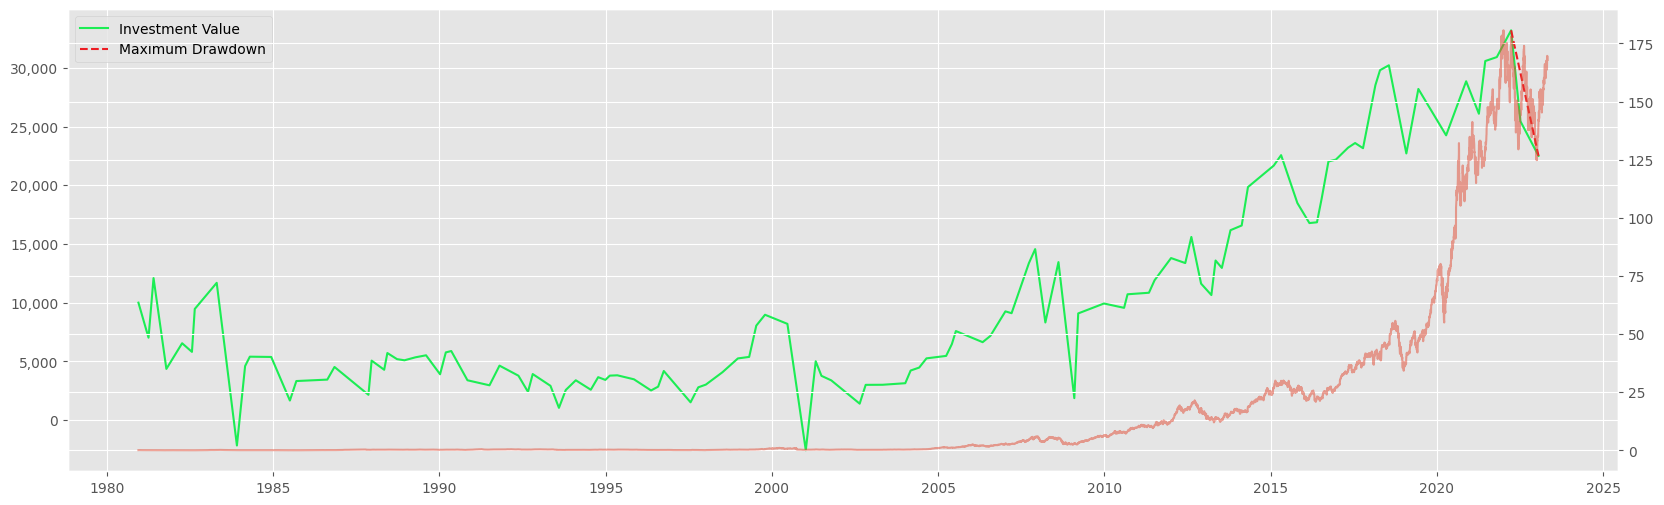

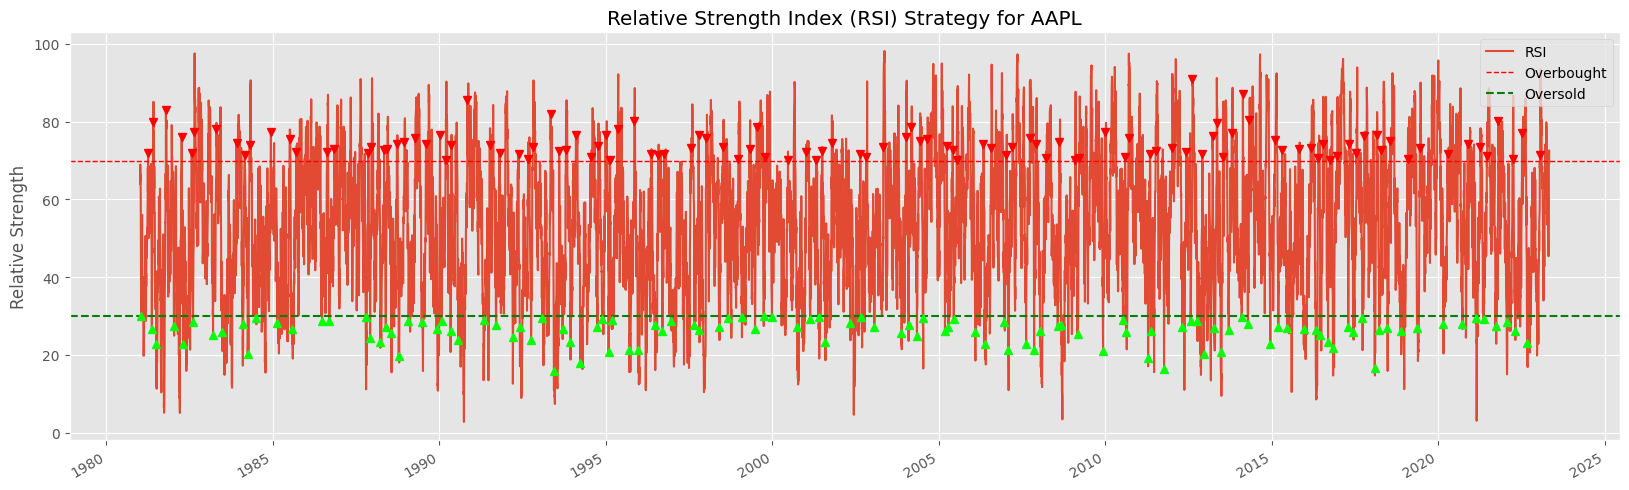

Portfolio initial value:  10,000.0
Portfolio Terminal Value:  25,486.86
Strategy Cumulative Return:  154.87 %
Average Trade Gross Profit: 132.37
Largest Profit:  2,752.6
Largest Loss:  -5,983.64
Total Trades:  234
Strategy Annualised Mean Return:  650.48 %
Total Log Return:  93.58 %
Strategy Annualised Volatility:  318.0 %
Strategy Sharpe Ratio:  1.5766460364891874
Strategy Maximum Drawdown:  -32.2 %


<ipython-input-36-61f2f84c280d>:174: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  exit_dates = pd.concat([exit_dates_series, pd.Series([np.nan] * (len(entries) - len(exit_dates)))])


,Entry Date,Entry Price,Shares Purchased,Exit Date,Exit Price,Gross Profit
0,1981-01-16,0.11,93000,1981-04-02,0.09,"-1,491.90"
1,1981-05-13,0.09,90014,1981-05-27,0.11,"1,795.23"
2,1981-06-30,0.09,114249,1981-10-15,0.06,"-2,972.10"
3,1982-01-11,0.06,113482,1982-04-06,0.06,-393.59
4,1982-04-22,0.05,130090,1982-07-23,0.05,-564.00
...,...,...,...,...,...,...
112,2021-05-12,121.52,219,2021-06-17,130.44,"1,955.20"
113,2021-09-20,141.69,201,2021-10-22,147.39,"1,145.66"
114,2022-01-19,165.02,180,2022-03-28,174.54,"1,714.29"
115,2022-04-25,161.90,194,2022-07-08,146.37,"-3,012.80"


In [37]:
rsi(security)


# Bollinger Bands:

*Explanation*:<br>
This algorithm uses the Bollinger Bands indicator to identify potential buy and sell signals based on volatility. When the price of an asset moves outside the upper or lower Bollinger Band, it may signal a reversal.<br>

**Trading Rules:**
- Buy signal: When the price of a security crosses below the lower band, it may signal a buy opportunity as the security is oversold and may experience an upward price movement.
- Sell signal: When the price of a security crosses above the upper band, it may signal a sell opportunity as the security is overbought and may experience a downward price movement.



In [34]:
#@title Run to set up Bollinger Bands function
def bollinger_bands(security):
    while True:
        try:
            investment_question = input('Do you want to specify an initial investment sum? Y/N (Default = 10K)')
            if investment_question.lower() == 'y': 
                investment = float(input('Please state initial investment amount: ' ))
            elif investment_question.lower() == 'n':
                investment = 10000   
            break
        except ValueError:
            print('Initial investment amount must be a number!')
        

    # Generate MACD Strategy:
    TP = (security['High'] + security['Low'] + security['Close'])/3 # Typical price
    n = 20 # smoothing period of one trading month
    MA = TP.rolling(n).mean() # Moving Average of typical price
    m = 2 # Number of standard deviations
    sigma = TP.rolling(n).std() # rolling standard deviation of typical price
    BOLU = MA + (m * sigma) # Upper BB
    BOLL = MA - (m * sigma) # Lower BB

    # Generate MACD Signals 
    bb_buy = pd.Series((BOLL > security['Adj Close']) & (BOLL.shift() < security['Adj Close'].shift())) # Oversold -- mean reversion or overcorrection.
    bb_sell = pd.Series((BOLU < security['Adj Close']) & (BOLU.shift() > security['Adj Close'].shift())) # Overbought -- mean reversion expected.


    # Set the first value of macd sell signals to False (No Short Selling):
    bb_sell.iloc[0] = False

    # Initialize variables for tracking the current state
    in_position = False
    entries = []
    entries_idxpos = []
    num_shares = []
    entries_value = []
    exits = []
    exits_idxpos = []
    exits_value = []
    profits = []
    investment = investment # starting investment amount
    investment_value = [investment] # initial investment

    # Loop over the index positions where signals occur
    for i in range(len(security)):
        # If we're not currently in a position and a macd buy signal occurs, enter a long position
        if not in_position and bb_buy[i]:
            in_position = True
            entries.append(security.iloc[i]["Adj Close"])
            entries_idxpos.append(i)
            num_shares.append(int(investment/security.iloc[i]["Adj Close"]))
            entries_value.append(num_shares[-1]*security.iloc[i]["Adj Close"])
        # If we're in a long position and a macd sell signal occurs, exit the position
        elif in_position and bb_sell[i]:
            in_position = False
            exits.append(security.iloc[i]["Adj Close"])
            exits_idxpos.append(i)
            exits_value.append(num_shares[-1]*security.iloc[i]["Adj Close"])
            profits.append(exits_value[-1] - entries_value[-1])
            investment += profits[-1]
            # Calculate the current value of the investment and append to investment_value
            current_value = investment + num_shares[-1]*(security.iloc[i]["Adj Close"] - entries[-1])
            investment_value.append(current_value)

            
        # Convert entries and exits values into arrays ahead of calculating log returns:
    entries_value_array = np.array(entries_value)
    exits_value_array = np.array(exits_value)

    # Check their shapes match to avoid ValueError:
    shape1 = entries_value_array.shape
    shape2 = exits_value_array.shape

    # If there is one more entry than exits remove the last entry as no returns can be caluclated anyway:
    if shape1 == shape2:
        pass
    elif shape1>shape2:
        entries_value_array = entries_value_array[:-1]

    # Calcualte the returns:
    log_returns = np.log(exits_value_array/entries_value_array)
    vol_returns = np.std(log_returns)
    annualised_vol = vol_returns*np.sqrt(252) # trading days in a year
    mean_return = np.mean(log_returns)
    annualised_mean = np.exp(mean_return*252)-1
    total_log_return = sum(log_returns)
    sharpe_ratio = ((annualised_mean-rf['TB3MS'].mean())/annualised_vol)

    entry_dates = security.index[entries_idxpos]
    exit_dates = security.index[exits_idxpos]
    total_profits = sum(profits)
    intial_investment = investment - total_profits
    portfolio_cum_returns = ((investment / intial_investment - 1))

    # Maximum Drawdown:
    investment_value_dates = security.index[exits_idxpos]
    investment_value_dates = investment_value_dates.insert(0, security.index[0]) # on first day the value was the initial investment sum 
    investment_value_series_with_date = pd.Series(investment_value, index=investment_value_dates)
    investment_value_series_with_date.name = 'Investment Value'
    investment_value_series_with_date.index.name = 'Date'
    peak_idx = investment_value_series_with_date.idxmax()
    trough_idx = investment_value_series_with_date[peak_idx:].idxmin()
    peak_value = investment_value_series_with_date[peak_idx]
    trough_value = investment_value_series_with_date[trough_idx]
    maximum_drawdown = (trough_value - peak_value) / (1+peak_value)

    # Plot max drawdown
    fig, ax1 = plt.subplots(figsize=(20,6))
    ax1.plot(investment_value_series_with_date, '#1CED54', label = 'Investment Value')
    # Obtain x and y values for maximum drawdown:
    x_values = [peak_idx, trough_idx]
    y_values = [peak_value, trough_value]
    ax1.plot(x_values, y_values, color = '#ed1d24', linestyle = '--', label = 'Maximum Drawdown')
    y_fmt = mtick.StrMethodFormatter('{x:,.0f}')
    ax1.yaxis.set_major_formatter(y_fmt)
    # Plot Adj Close
    ax2 = ax1.twinx()
    ax2.plot(security['Adj Close'], alpha = 0.5)
    ax1.legend(loc='upper left')
    plt.show();

    # Plot the BB lines and close:
    # Set up plots:
    fig, ax = plt.subplots(figsize=(20,6))
    plt.title(f'Bollinger Bands Strategy for {ticker.upper()}')
    plt.ylabel('Price')
    plt.plot(security['Adj Close'], label = 'Adj Close')
    plt.plot(BOLU, label = 'Upper Bollinger Band')
    plt.plot(BOLL, label = 'Lower Bollinger Band', color = 'brown')
    ax.fill_between(security.index, BOLU, BOLL, color='gray', alpha = 0.2)
    ax.plot(security['Adj Close'][entry_dates], marker = '^', color = '#08FF08', linestyle = '')
    ax.plot(security['Adj Close'][exit_dates], marker = 'v', color = 'red', linestyle = '')
    plt.legend(loc='best')
    fig.autofmt_xdate()
    plt.show()

    print('Portfolio initial value: ', format(intial_investment, ','))
    print('Portfolio Terminal Value: ', format(round(investment, 2), ','))
    print("Strategy Cumulative Return: ", round(portfolio_cum_returns*100, 2), "%")
    print("Average Trade Gross Profit:", round(sum(profits)/len(profits), 2))
    print("Largest Profit: ", format(round(max(profits), 2), ','))
    print("Largest Loss: ", format(round(min(profits), 2), ','))
    print("Total Trades: ", len(entries)+len(exits))
    print("Strategy Annualised Mean Return: ", round(annualised_mean*100, 2), "%")
    print("Total Log Return: ", round(total_log_return*100, 2), "%")
    print("Strategy Annualised Volatility: ", round(annualised_vol, 2)*100, "%")
    print("Strategy Sharpe Ratio: ", sharpe_ratio)
    print("Strategy Maximum Drawdown: ", round(maximum_drawdown*100, 2), "%")

    # Create Orderbook:
    exit_dates_list = exit_dates.to_list()
    exit_dates_series = pd.Series(exit_dates_list)
    entry_dates_list = entry_dates.to_list()
    entry_dates_series = pd.Series(entry_dates_list)
    max_len = len(entry_dates_series)

    # Use a for loop to append NaN values to each array until its length matches the maximum length.
    for arr in [entries, num_shares, exits, profits]:
        arr.extend([np.nan] * (max_len - len(arr)))
    # Extend the Exit dates:
    exit_dates = pd.concat([exit_dates_series, pd.Series([np.nan] * (len(entries) - len(exit_dates)))])
    # Create a dictionary of the orderbook components:
    data = {'Entry Date': entry_dates_series,
            'Entry Price': entries, 
            'Shares Purchased': num_shares, 
            'Exit Date':exit_dates_series, 
            'Exit Price': exits, 
            'Gross Profit': profits}
    pd.options.display.float_format = '{:,.2f}'.format

    orderbook = pd.DataFrame(data)


 
    return orderbook

Do you want to specify an initial investment sum? Y/N (Default = 10K)n


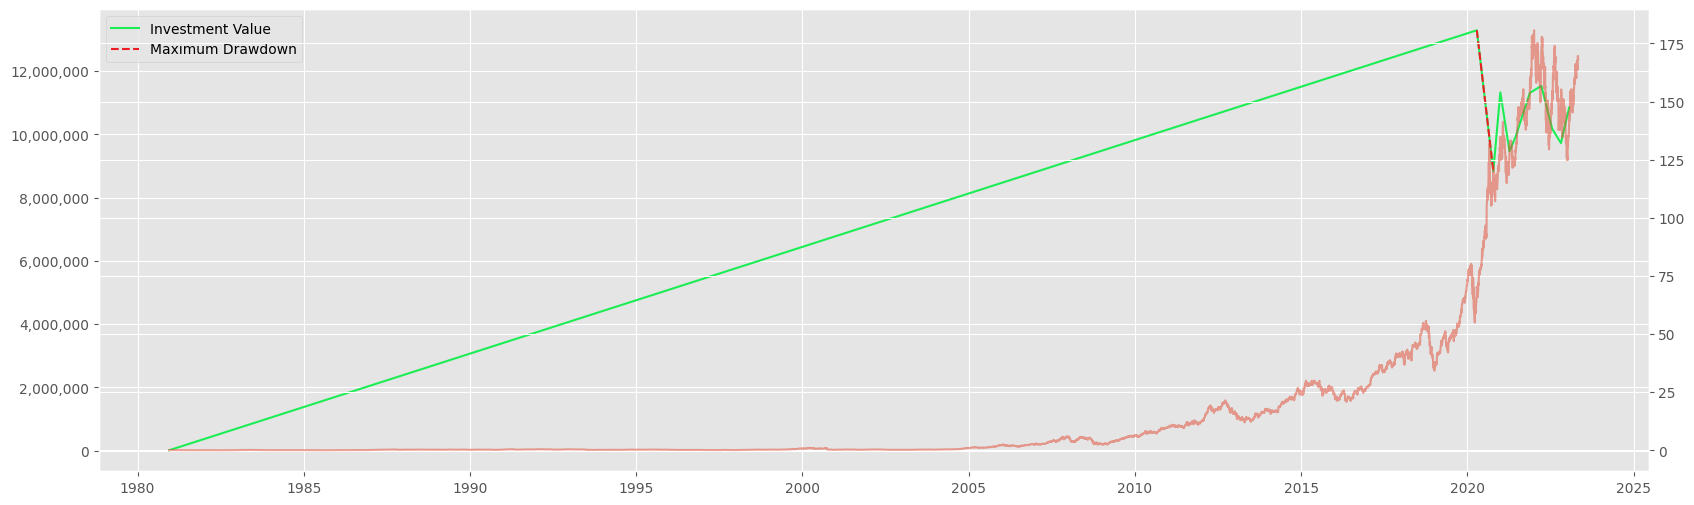

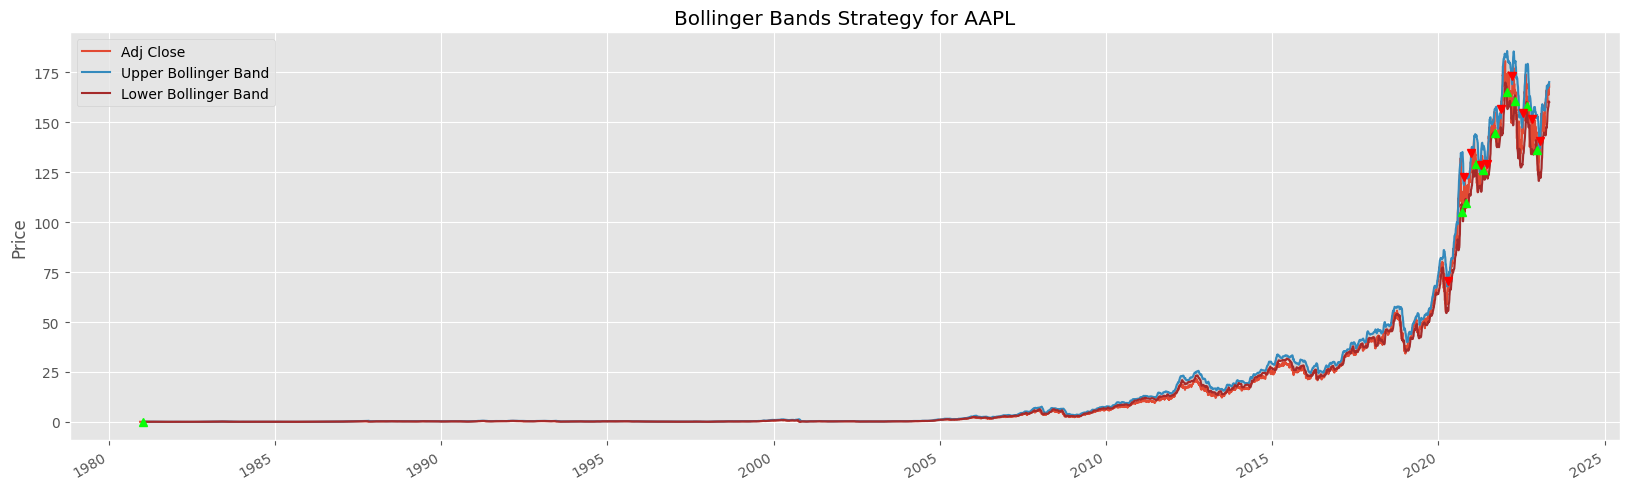

Portfolio initial value:  10,000.0
Portfolio Terminal Value:  10,505,063.2
Strategy Cumulative Return:  104950.63 %
Average Trade Gross Profit: 1049506.32
Largest Profit:  6,641,112.25
Largest Loss:  -438,247.33
Total Trades:  20
Strategy Annualised Mean Return:  1.37810441182263e+78 %
Total Log Return:  695.7 %
Strategy Annualised Volatility:  3074.0 %
Strategy Sharpe Ratio:  4.4836138546907756e+74
Strategy Maximum Drawdown:  -33.51 %


<ipython-input-34-e3f2caa98e18>:162: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  exit_dates = pd.concat([exit_dates_series, pd.Series([np.nan] * (len(entries) - len(exit_dates)))])


,Entry Date,Entry Price,Shares Purchased,Exit Date,Exit Price,Gross Profit
0,1981-01-13,0.11,94525,2020-04-14,70.36,"6,641,112.25"
1,2020-09-18,105.23,63205,2020-10-12,122.53,"1,093,156.40"
2,2020-10-28,109.52,70708,2020-12-28,134.86,"1,791,612.07"
3,2021-02-17,129.28,73759,2021-04-08,128.81,"-34,985.33"
4,2021-05-04,126.33,75207,2021-06-14,129.15,"211,911.01"
5,2021-09-17,144.78,67084,2021-11-18,156.72,"800,663.75"
6,2022-01-19,165.02,63710,2022-03-24,173.02,"509,873.46"
7,2022-04-22,160.82,68546,2022-07-21,154.64,"-423,226.78"
8,2022-08-30,158.40,66917,2022-10-25,151.86,"-438,247.33"
9,2022-12-15,136.29,74559,2023-01-23,140.89,"343,193.70"


In [35]:
bollinger_bands(security)

# ICHIMOKU CLOUD:

*Explanation*:<br>
This algorithm uses the Ichimoku Cloud indicator to identify support and resistance levels, trend direction, and momentum. When the price of an asset moves above or below the cloud, it may signal a potential trend reversal.<br>

**Trading Rules**:

- Kumo Breakout: The Kumo (cloud) is the space between the Senkou Span A and Senkou Span B lines. When the price moves above the Kumo, it's considered a bullish signal, and when it moves below, it's considered bearish. Traders use this signal to enter and exit trades.

- Tenkan-Kijun Cross: The Tenkan-Sen (Conversion Line) and Kijun-Sen (Base Line) are two moving averages that cross over each other. A bullish signal is when the Tenkan-Sen crosses above the Kijun-Sen, and a bearish signal is when the Tenkan-Sen crosses below the Kijun-Sen. Traders use this signal to enter and exit trades.

- Chikou Span: The Chikou Span (Lagging Span) is the current price plotted 26 periods behind. When the Chikou Span crosses above or below the price, it's considered a bullish or bearish signal, respectively.

- Price-Kumo relationship: The relationship between the price and the Kumo is also important. When the price is above the Kumo, it's considered a bullish signal, and when it's below, it's bearish.


In [29]:
#@title Run to set up Ichimoku Cloud function
def ichimoku_cloud (security):
    while True:
        try:
            investment_question = input('Do you want to specify an initial investment sum? Y/N (Default = 10K)')
            if investment_question.lower() == 'y': 
                investment = float(input('Please state initial investment amount: ' ))
            elif investment_question.lower() == 'n':
                investment = 10000    
            break
        except ValueError:
            print('Initial investment amount must be a number!')
        

    # Ichimoku Cloud:

    # Tenkan-Sen (Conversion Line):
    high_9 = security['High'].rolling(9).max() 
    low_9 = security['Low'].rolling(9).min()
    tenkan_sen = (high_9+low_9)/2

    # Kijun-Sen (Base Line):
    high_26 = security['High'].rolling(26).max()
    low_26 = security['Low'].rolling(26).min()
    kijun_sen = (high_26+low_26)/2

    # Senkou Span A (Leading Span A):
    senkou_span_A = ((tenkan_sen+kijun_sen)/2).shift(26)

    # Senkou Span B (Leading Span B):
    high_52 = security['High'].rolling(52).max()
    low_52 = security['Low'].rolling(52).min()
    senkou_span_B = ((high_52+low_52)/2).shift(26)

    # Chikou Span (Lagging 26 period Close price):
    chikou_span = security['Close'].shift(-26)

    ichimoku_buy = pd.Series((security['Adj Close']>senkou_span_A) & (security['Adj Close'].shift()<senkou_span_A.shift()) & (security['Adj Close']>senkou_span_B)
                                & (security['Adj Close'].shift()<senkou_span_B.shift()) & (chikou_span > security['Adj Close']) & 
                                (chikou_span.shift() < security['Adj Close'].shift()) | ((tenkan_sen > kijun_sen) & (tenkan_sen.shift() < kijun_sen.shift()))) # Bullish

    ichimoku_sell = pd.Series((security['Adj Close']<senkou_span_A) & (security['Adj Close'].shift()>senkou_span_A.shift()) & (security['Adj Close']<senkou_span_B)
                                & (security['Adj Close'].shift()>senkou_span_B.shift()) & (chikou_span < security['Adj Close']) & 
                                (chikou_span.shift() > security['Adj Close'].shift()) | ((tenkan_sen < kijun_sen) & (tenkan_sen.shift() > kijun_sen.shift()))) # Bearish

    # Create cloud color array
    cloud_color = np.where(senkou_span_A > senkou_span_B, 'green', 'red')

   

    # Set the first value of macd sell signals to False (No Short Selling):
    ichimoku_sell.iloc[0] = False

    # Initialize variables for tracking the current state
    in_position = False
    entries = []
    entries_idxpos = []
    num_shares = []
    entries_value = []
    exits = []
    exits_idxpos = []
    exits_value = []
    profits = []
    investment = investment # starting investment amount
    investment_value = [investment] # initial investment

    # Loop over the index positions where signals occur
    for i in range(len(security)):
        # If we're not currently in a position and a macd buy signal occurs, enter a long position
        if not in_position and ichimoku_buy[i]:
            in_position = True
            entries.append(security.iloc[i]["Adj Close"])
            entries_idxpos.append(i)
            num_shares.append(int(investment/security.iloc[i]["Adj Close"]))
            entries_value.append(num_shares[-1]*security.iloc[i]["Adj Close"])
        # If we're in a long position and a macd sell signal occurs, exit the position
        elif in_position and ichimoku_sell[i]:
            in_position = False
            exits.append(security.iloc[i]["Adj Close"])
            exits_idxpos.append(i)
            exits_value.append(num_shares[-1]*security.iloc[i]["Adj Close"])
            profits.append(exits_value[-1] - entries_value[-1])
            investment += profits[-1]
        # Calculate the current value of the investment and append to investment_value
            current_value = investment + num_shares[-1]*(security.iloc[i]["Adj Close"] - entries[-1])
            investment_value.append(current_value)

    # Convert entries and exits values into arrays ahead of calculating log returns:
    entries_value_array = np.array(entries_value)
    exits_value_array = np.array(exits_value)

    # Check their shapes match to avoid ValueError:
    shape1 = entries_value_array.shape
    shape2 = exits_value_array.shape

    # If there is one more entry than exits remove the last entry as no returns can be caluclated anyway:
    if shape1 == shape2:
        pass
    elif shape1>shape2:
        entries_value_array = entries_value_array[:-1]

    # Calcualte the returns:
    log_returns = np.log(exits_value_array/entries_value_array)
    vol_returns = np.std(log_returns)
    annualised_vol = vol_returns*np.sqrt(252) # trading days in a year
    mean_return = np.mean(log_returns)
    annualised_mean = np.exp(mean_return*252)-1
    total_log_return = sum(log_returns)
    sharpe_ratio = ((annualised_mean-rf['TB3MS'].mean())/annualised_vol)

    entry_dates = security.index[entries_idxpos]
    exit_dates = security.index[exits_idxpos]
    total_profits = sum(profits)
    intial_investment = investment - total_profits
    portfolio_cum_returns = ((investment / intial_investment - 1))



     # Maximum Drawdown:
    investment_value_dates = security.index[exits_idxpos]
    investment_value_dates = investment_value_dates.insert(0, security.index[0]) # on first day the value was the initial investment sum 
    investment_value_series_with_date = pd.Series(investment_value, index=investment_value_dates)
    investment_value_series_with_date.name = 'Investment Value'
    investment_value_series_with_date.index.name = 'Date'
    peak_idx = investment_value_series_with_date.idxmax()
    trough_idx = investment_value_series_with_date[peak_idx:].idxmin()
    peak_value = investment_value_series_with_date[peak_idx]
    trough_value = investment_value_series_with_date[trough_idx]
    maximum_drawdown = (trough_value - peak_value) / (1+peak_value)

     # Plot max drawdown
    fig, ax1 = plt.subplots(figsize=(20,6))
    ax1.plot(investment_value_series_with_date, '#1CED54', label = 'Investment Value')
    # Obtain x and y values for maximum drawdown:
    x_values = [peak_idx, trough_idx]
    y_values = [peak_value, trough_value]
    ax1.plot(x_values, y_values, color = '#ed1d24', linestyle = '--', label = 'Maximum Drawdown')
    y_fmt = mtick.StrMethodFormatter('{x:,.0f}')
    ax1.yaxis.set_major_formatter(y_fmt)
    # Plot Adj Close
    ax2 = ax1.twinx()
    ax2.plot(security['Adj Close'], alpha = 0.5)
    ax1.legend(loc='upper left')
    plt.show();

    # Plot the strategy:
    fig, ax = plt.subplots(figsize=(20,6))
    ax.fill_between(security.index, senkou_span_A, senkou_span_B, where = senkou_span_A>senkou_span_B, interpolate = True, color='green', label = 'Ichimoku Cloud (Bullish)')
    ax.fill_between(security.index, senkou_span_A, senkou_span_B, where = senkou_span_A<=senkou_span_B, interpolate = True, color = 'red', label = 'Ichimoku Cloud (Bearish)')
    plt.plot(security['Adj Close'], label = 'Adj Close')
    plt.plot(chikou_span, label = 'Chikou Span')
    ax.plot(security['Adj Close'][entry_dates], marker = '^', color = '#08FF08', linestyle = '')
    ax.plot(security['Adj Close'][exit_dates], marker = 'v', color = 'red', linestyle = '')
    plt.legend(loc='best')
    plt.title(f'Ichimoku Cloud Strategy for {ticker.upper()}')
    plt.ylabel('Price')
    plt.show();


   

    # Create Orderbook:
    exit_dates_list = exit_dates.to_list()
    exit_dates_series = pd.Series(exit_dates_list)
    entry_dates_list = entry_dates.to_list()
    entry_dates_series = pd.Series(entry_dates_list)
    max_len = len(entry_dates_series)

    # Use a for loop to append NaN values to each array until its length matches the maximum length.
    for arr in [entries, num_shares, exits, profits]:
        arr.extend([np.nan] * (max_len - len(arr)))
    # Extend the Exit dates:
    exit_dates = pd.concat([exit_dates_series, pd.Series([np.nan] * (len(entries) - len(exit_dates)))])
    # Create a dictionary of the orderbook components:
    data = {'Entry Date': entry_dates_series,
            'Entry Price': entries, 
            'Shares Purchased': num_shares, 
            'Exit Date':exit_dates_series, 
            'Exit Price': exits, 
            'Gross Profit': profits}
    pd.options.display.float_format = '{:,.2f}'.format

    orderbook = pd.DataFrame(data)


    print('Portfolio initial value: ', format(intial_investment, ','))
    print('Portfolio Terminal Value: ', format(round(investment, 2), ','))
    print("Strategy Cumulative Return: ", round(portfolio_cum_returns*100, 2), "%")
    print("Average Trade Gross Profit:", round(sum(profits)/len(profits), 2))
    print("Largest Profit: ", format(round(max(profits), 2), ','))
    print("Largest Loss: ", format(round(min(profits), 2), ','))
    print("Total Trades: ", len(entries)+len(exits))
    print("Strategy Annualised Mean Return: ", round(annualised_mean*100, 2), "%")
    print("Total Log Return: ", round(total_log_return*100, 2), "%")
    print("Strategy Annualised Volatility: ", round(annualised_vol, 2)*100, "%")
    print("Strategy Sharpe Ratio: ", sharpe_ratio)
    print("Strategy Maximum Drawdown: ", round(maximum_drawdown*100, 2), "%")
    return orderbook


Do you want to specify an initial investment sum? Y/N (Default = 10K)n


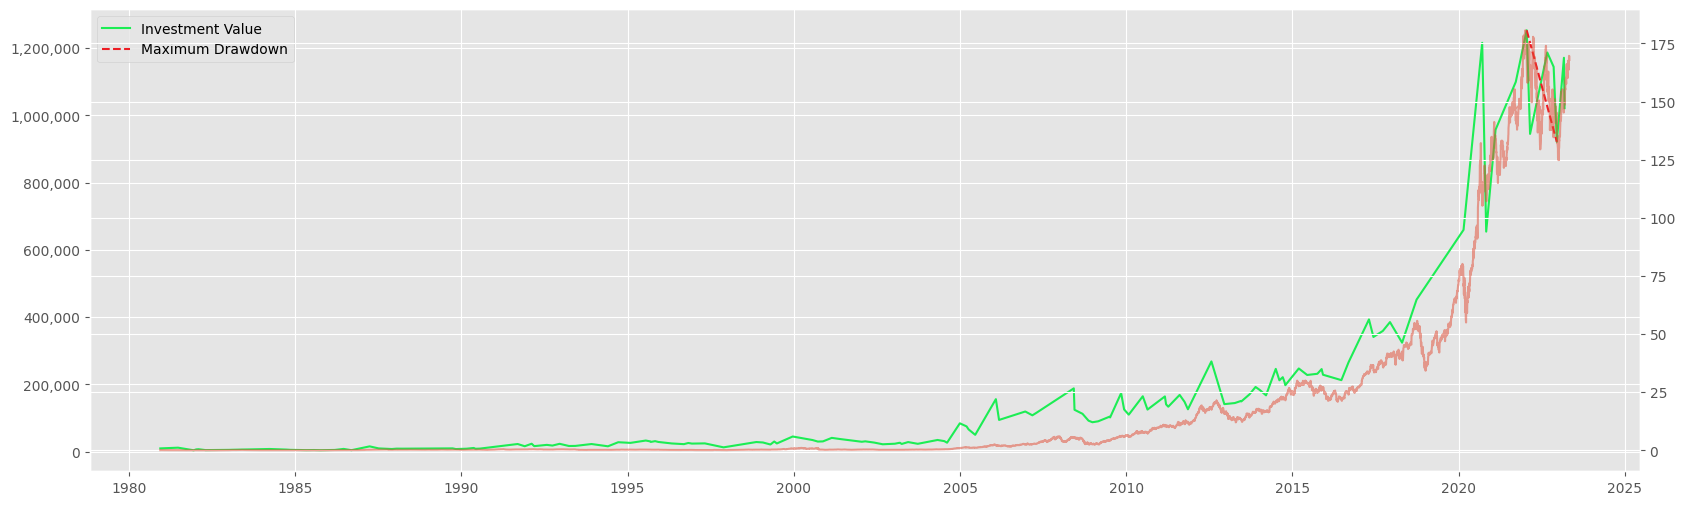

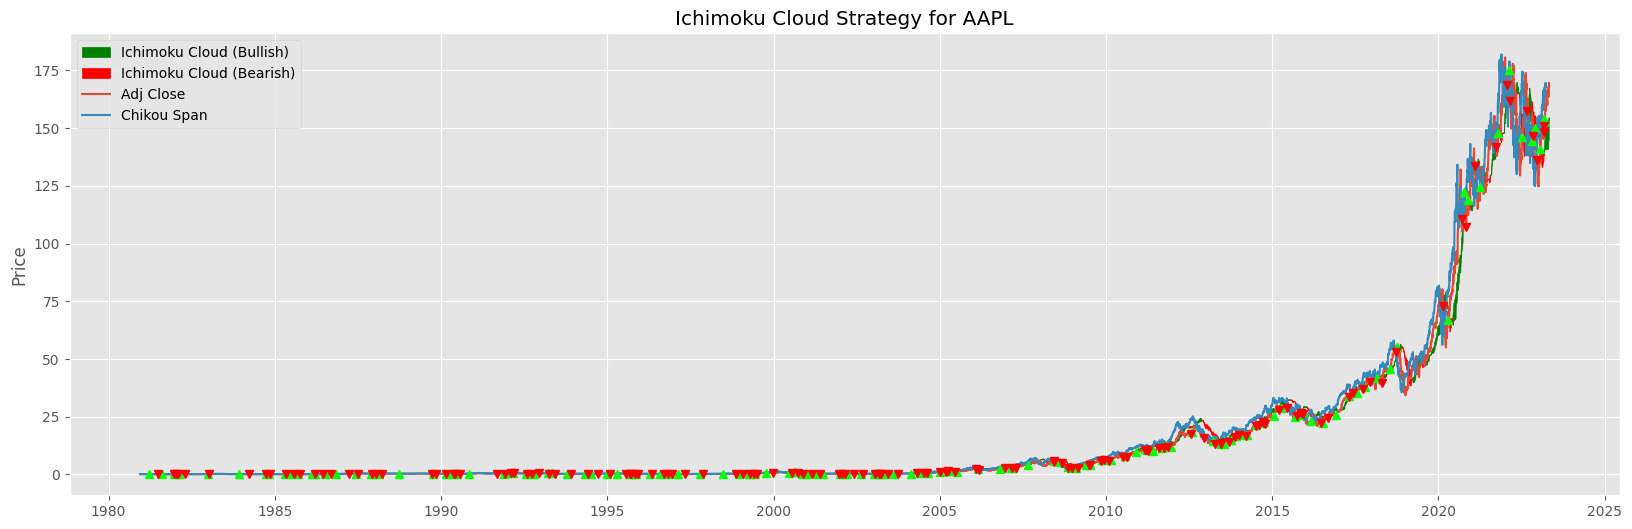

Portfolio initial value:  10,000.0
Portfolio Terminal Value:  1,059,383.48
Strategy Cumulative Return:  10493.83 %
Average Trade Gross Profit: nan
Largest Profit:  343,244.6
Largest Loss:  -108,962.33
Total Trades:  286
Strategy Annualised Mean Return:  392408.17 %
Total Log Return:  466.3 %
Strategy Annualised Volatility:  248.0 %
Strategy Sharpe Ratio:  1580.860134774029
Strategy Maximum Drawdown:  -26.47 %


,Entry Date,Entry Price,Shares Purchased,Exit Date,Exit Price,Gross Profit
0,1981-03-24,0.09,108282,1981-06-25,0.10,"1,079.74"
1,1981-08-05,0.09,123452,1981-12-14,0.06,"-3,318.55"
2,1981-12-16,0.07,114746,1982-01-11,0.06,-348.33
3,1982-01-27,0.07,109596,1982-02-04,0.07,95.03
4,1982-02-09,0.06,117002,1982-04-23,0.05,"-1,268.23"
...,...,...,...,...,...,...
138,2022-10-27,144.34,7680,2022-11-10,146.65,"17,712.19"
139,2022-11-22,149.95,7511,2022-12-15,136.29,"-102,593.75"
140,2023-01-23,140.89,7266,2023-03-03,151.03,"73,641.76"
141,2023-03-06,153.83,7133,2023-03-10,148.50,"-38,018.90"


In [30]:
ichimoku_cloud(security)

### How did you compare to *buy-and-hold* on the S&P500?

In [25]:
#@title Run to download SPY data
spy = yf.download('spy', None, None)
spy.index = spy.index.date


[*********************100%***********************]  1 of 1 completed


Do you want to specify an initial investment sum? Y/N (Default = 10K)n


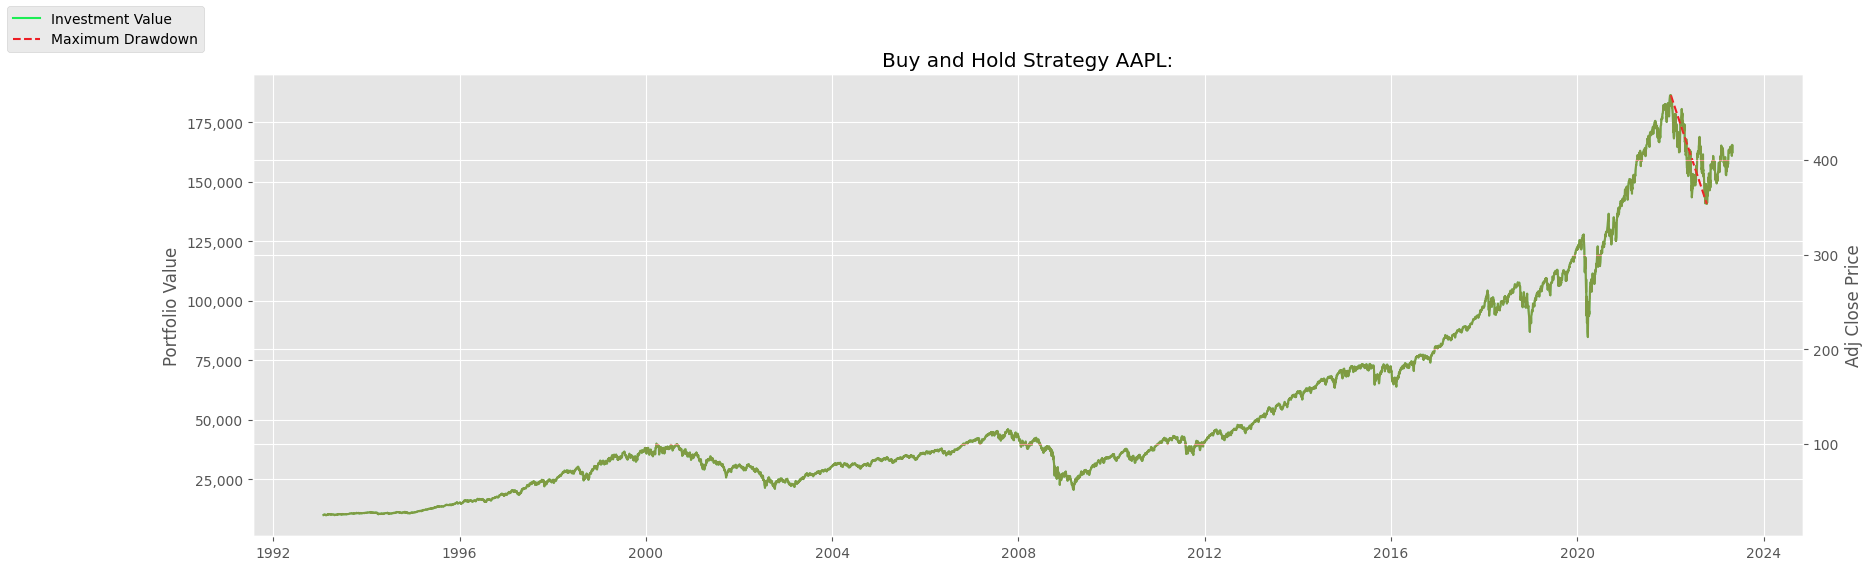

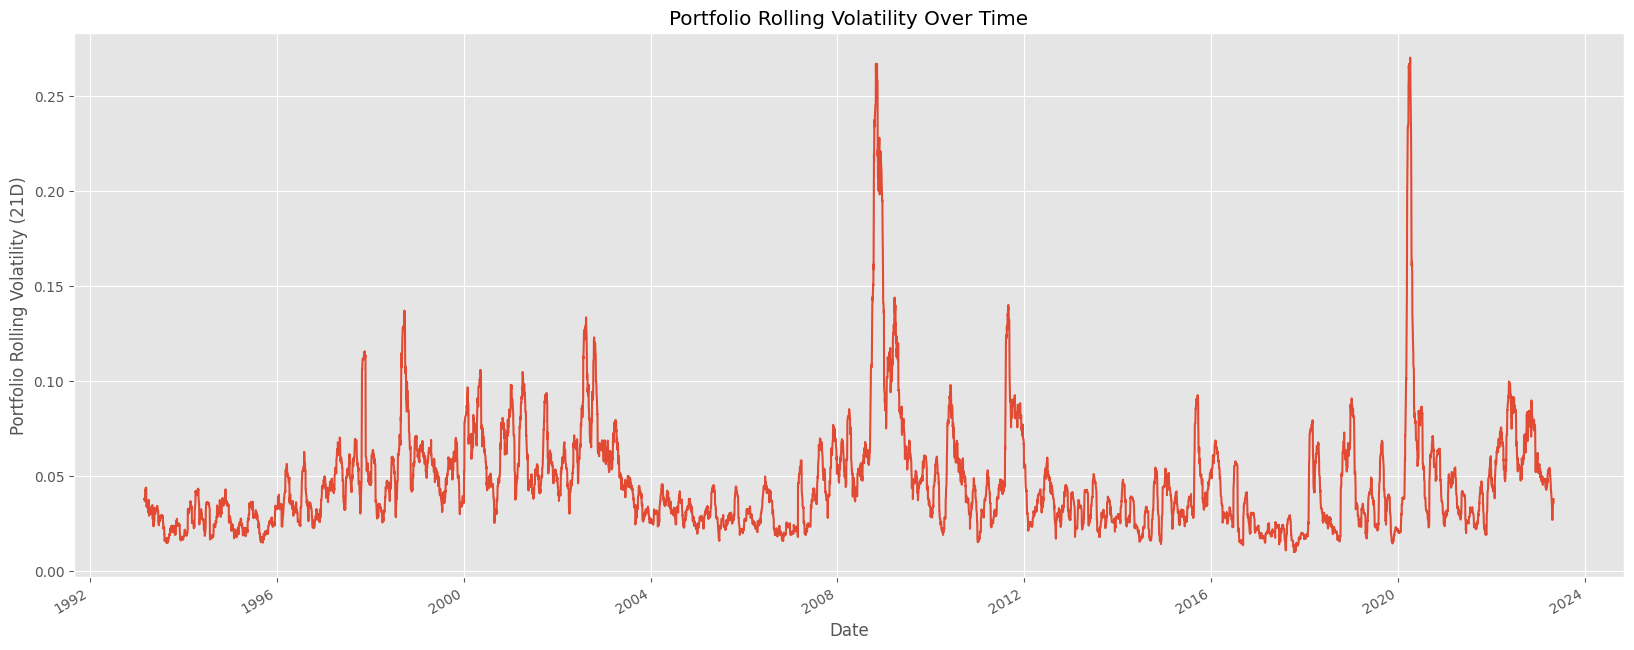

Initial Investment: 10,000
Cumulative Portfolio Return:  1524.60 %
Terminal Portfolio Value:  162,459.62
No. Purchased:  398
Annualised Average Portfolio Return:  9.66 %
Annualised Portfolio Volatility:  18.91 %
Portfolio Sharpe Ratio: -7.35
Portfolio Maximum Drawdown: -24.50 %


In [33]:
buy_and_hold(spy)

# DISCLAIMER:

*Please note that the Python backtesting notebook provided is for educational and informational purposes only. It is not intended to be, nor can it be considered, financial advice. Any actions taken by individuals who use this notebook are at their own risk and discretion. The notebook's author cannot be held responsible for any losses or damages resulting from the use of this notebook. Users should consult with a licensed financial professional before making any investment decisions.*